In [97]:
import os
import pandas as pd
import numpy as np
from numpy import linalg as LA
import nltk
from alive_progress import alive_bar

ROOT_DIR = os.path.dirname(os.path.abspath("__file__"))
PARENT_DIR = os.path.dirname(ROOT_DIR)
GUARDIAN_DIR = os.path.join(ROOT_DIR, "data", "Guardian.csv")
REUTERS_DIR = os.path.join(ROOT_DIR, "data", "Reuters.csv")

In [120]:
def load_glove_model(terms):
    common_vectors = []
    with open(os.path.join(ROOT_DIR, "glove_data", "results", "vectors.txt"), "r") as f:
        for line in f:
            if line.split(None, 1)[0] in terms:
                common_vectors.append(line.replace("\n", ""))

    glove_model = {}
    for line in common_vectors:
        split_line = line.split()
        word = split_line[0]
        embedding = np.array(split_line[1:], dtype=np.float64)
        glove_model[word] = embedding
    return glove_model


def article_index(article_text):

    # dictionaries
    economic_terms = ["economy", "economic"]
    uncertainty_terms = []
    with open(os.path.join(ROOT_DIR, "data", "LoughranMcDonald_Uncertainty.txt"), "r") as f:
        for line in f:
            uncertainty_terms.append(line.lower().replace("\n", ""))
    article_vocab = [word.lower() for word in nltk.word_tokenize(article_text) if word.isalpha()]

    common_uncertainty_terms = list(set(article_vocab).intersection(uncertainty_terms))
    common_economic_terms = list(set(article_vocab).intersection(economic_terms))

    if len(common_economic_terms) == 0 or len(common_uncertainty_terms) == 0:
        return None

    # index
    common_uncertainty_vectors = load_glove_model(common_uncertainty_terms)
    common_economic_vectors = load_glove_model(common_economic_terms)

    common_uncertainty_matrix = np.array(list(common_uncertainty_vectors.values()))
    common_economic_matrix = np.array(list(common_economic_vectors.values()))

    norm_uncertainty_matrix = LA.norm(common_uncertainty_matrix)
    norm_economic_matrix = LA.norm(common_economic_matrix)

    sum_common_uncertainty_terms = np.sum(common_uncertainty_matrix, axis=0)
    sum_common_economic_terms = np.sum(common_economic_matrix, axis=0)

    inner = (sum_common_economic_terms / norm_economic_matrix) - (sum_common_uncertainty_terms / norm_uncertainty_matrix)
    index = 1 / LA.norm(inner)

    return index


def daily_index(dataframe):

    data = pd.DataFrame(columns=["Date", "Text", "Norm", "Uncertainty"])
    text = ""
    date = dataframe.iloc[0, 0]
    for i in range(0, len(dataframe) ):
        if dataframe.loc[i, "Date"] == date:
            text += dataframe.loc[i, "Text"]
        else:
            data.loc[i - 1, "Text"] = text
            data.loc[i - 1, "Date"] = date
            text = ""
            date = dataframe.loc[i, "Date"]

    with alive_bar(len(data), title="→ Calculating daily norms", spinner="dots_waves", bar="smooth", force_tty=True) as bar:
        for i in range(0, len(data) ):
            daily_vocab = [word.lower() for word in nltk.word_tokenize(data.iloc[i, 1]) if word.isalpha()]
            daily_vectors = load_glove_model(daily_vocab)
            daily_matrix = np.array(list(daily_vectors.values()))
            daily_norm = LA.norm(daily_matrix)
            data.iloc[i, 2] = daily_norm
            bar()

    with alive_bar(len(dataframe), title="→ Calculating indexes", spinner="dots_waves", bar="smooth", force_tty=True) as bar:
        date = dataframe.iloc[0, 0]
        index = 0
        for i in range(0, len(dataframe)):
            if dataframe.loc[i, "Date"] == date:
                _ = article_index(dataframe.loc[i, "Text"])
                if _ is not None:
                    index += _
            else:
                data.loc[i - 1, "Uncertainty"] = index / data.loc[i - 1, "Norm"]
                index = 0
                date = dataframe.loc[i, "Date"]
            bar()

    data = data.drop(columns='Norm')
    return data


In [124]:
guardian = pd.read_csv(GUARDIAN_DIR)
guardian_index = daily_index(guardian)

→ Calculating daily norms |████████████████████████████████████████| 393/393 [100%] in 10:29.4 (0.62/s)                                                   | ⠐⠠⢀⡀⠄ 34/393 [9%] in 41s (0.8/s, eta: 6:56) |████████▍                               | ⠠⢀⡀⠄⠂ 82/393 [21%] in 1:55 (0.7/s, eta: 7:16) |███████████▊                            | ⠂⠁⠈⠐⠠ 116/393 [30%] in 3:10 (0.6/s, eta: 7:33) |███████████████▊                        | ⠈⠐⠠⢀⡀ 155/393 [39%] in 5:28 (0.5/s, eta: 8:18) |███████████████▊                        | ⡀⠄⠂⠁⠈ 155/393 [39%] in 5:30 (0.5/s, eta: 8:18) |████████████████▏                       | ⠈⠐⠠⢀⡀ 159/393 [40%] in 5:50 (0.5/s, eta: 8:30) |████████████████▋                       | ⢀⡀⠄⠂⠁ 163/393 [41%] in 6:17 (0.4/s, eta: 8:43) |█████████████████▎                      | ⠁⠈⠐⠠⢀ 169/393 [43%] in 7:09 (0.4/s, eta: 9:13) |███████████████████▌                    | ⠐⠠⢀⡀⠄ 192/393 [49%] in 9:29 (0.3/s, eta: 9:59) 


on 3705: /var/folders/xd/g9cbpcws3m14495hf_1bxjyh0000gn/T/ipykernel_99872/1106129321.py:84: RuntimeWarning: invalid value encountered in double_scalars
           data.loc[i - 1, "Uncertainty"] = index / data.loc[i - 1, "Norm"]


→ Calculating indexes |████████████████████████████████████████| 4031/4031 [100%] in 49.1s (82.10/s)                    


In [130]:


guardian_index['Date'] = pd.to_datetime(guardian_index['Date'])

guardian_index.set_index('Date',inplace=True,drop=True)
guardian_index.head()

,Text,Uncertainty
Date,,
2022-08-24,Ukraine is bracing for possible Russian strik...,0.0
2022-08-23,Volodymyr Zelenskiy warned that any attacks by...,0.012923
2022-08-22,The influential head of Russia’s RT news netwo...,0.009084
2022-08-21,Every nation has its founding myths and narrat...,0.003048
2022-08-20,It was early in the evening of 21 February tha...,0.011948


In [66]:
guardian = pd.read_csv(GUARDIAN_DIR)

indexes = []
dates = []
with alive_bar(4031, title="→ Calculating indexes", spinner="dots_waves", bar="smooth", force_tty=True) as bar:
    for i in range (0,4031):
        bar()
        _ = index(guardian.iloc[i,3])
        if _ is not None:
            indexes.append(_)
            dates.append(guardian.iloc[i,0])
guardian_unc_df = pd.DataFrame({'Date':dates,'Index':indexes})
guardian_unc_df.set_index('Date')
guardian_unc_df['Date'] = pd.to_datetime(guardian_unc_df['Date'])


→ Calculating indexes |████████████████████████████████████████| 4031/4031 [100%] in 53.7s (75.10/s)                    


In [96]:
guardian_unc_dsum = guardian_unc_df.resample('D', on='Date').sum()
final = pd.concat([guardian_unc_dsum,daily_guardian])
final.tail(100)

,Index,Text,Norm
Date,,,
2021-10-22,NaN,,0.0
2021-10-21,NaN,Moscow authorities have announced a weeklong c...,92.906344
2021-10-20,NaN,"Their movie props floated around, sleeping was...",68.895152
2021-10-18,NaN,,0.0
2021-10-17,NaN,French mayors and residents along the Normandy...,73.152234
...,...,...,...
2021-04-11,NaN,,0.0
2021-04-09,NaN,,0.0
2021-04-06,NaN,Ukraine’s president has called on Nato and key...,69.446368


In [ ]:
reuters = pd.read_csv(REUTERS_DIR)

indexes = []
dates = []
with alive_bar(12355, title="→ Calculating indexes", spinner="dots_waves", bar="smooth", force_tty=True) as bar:
    for i in range (0,12355):
        bar()
        _ = index(reuters.iloc[i,3])
        if _ is not None:
            indexes.append(_)
            dates.append(reuters.iloc[i,0])
reuters_unc_df = pd.DataFrame({'Date':dates,'Uncertainty':indexes})
reuters_unc_df.set_index('Date')


In [ ]:
reuters_unc_df['Date'] = pd.to_datetime(reuters_unc_df['Date'])
reuters_unc_davg = reuters_unc_df.resample('D', on='Date').mean()
guardian_unc_df['Date'] = pd.to_datetime(guardian_unc_df['Date'])
guardian_unc_davg = guardian_unc_df.resample('D', on='Date').mean()

In [125]:

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime as dt
def scatter_plot(data,title,xlabel,ylabel):

       fig, ax = plt.subplots(figsize=(25, 3))

       beginning = dt.date(2022, 1, 1)
       end = dt.date.today()

       ax.plot(data.index.values,
              data['Uncertainty'],
              color='purple',
              #linewidths=0
              )

       ax.set(
              #xlabel=xlabel,
              #ylabel=ylabel,
              title=title
              )

       date_form = DateFormatter("%m-%y")
       ax.xaxis.set_major_formatter(date_form)
       ax.set_xbound(beginning, end)

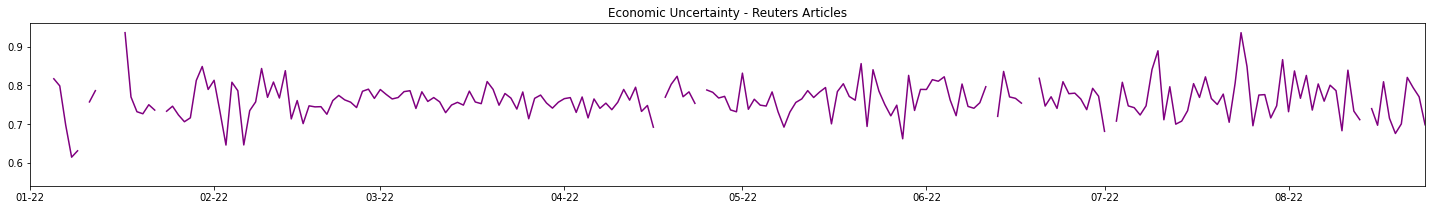

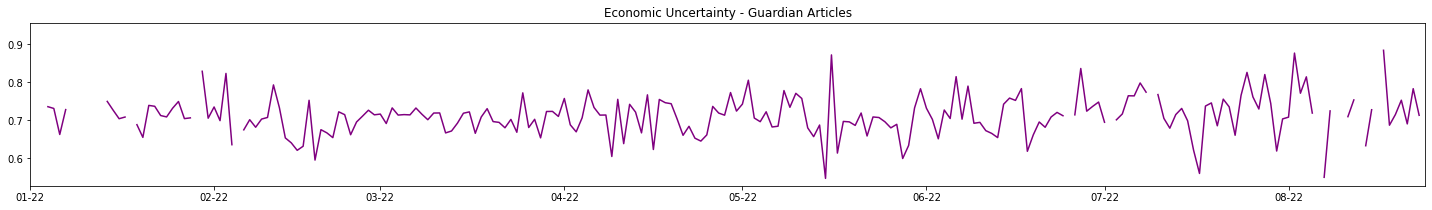

In [ ]:
scatter_plot(reuters_unc_davg,"Economic Uncertainty - Reuters Articles","","")
scatter_plot(guardian_unc_davg,"Economic Uncertainty - Guardian Articles","","")

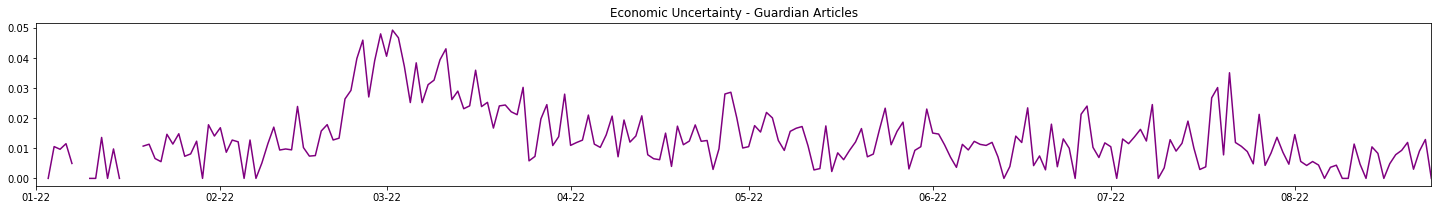

In [131]:
scatter_plot(guardian_index,"Economic Uncertainty - Guardian Articles","","")